# Fuzzy upravljanje poljoprivrednom proizvodnjom u plasteniku

____
#### Vizualni prikaz posvećenosti tima Burek s Bistrika
<center><img src="Tim_Burek_s_Bistrika.jpg" alt="drawing" width="50%"/></center>

### KRATAK OPIS PROBLEMA 
<p>
 Kao što nam je poznato u plastenicima i staklenicima se vrlo brzo mijenjaju klimatski uvjeti
 i zbog toga nam je potrebna automatska regulacija ventilacije kako bi se potpuno iskoristila funkcionalnost objekata.

Zbog previsoke temperature u objektu dolazi do izduživanja internodija na biljkama dok preniska 
temperatura zaustavlja njezin rast. Kod ručnog otvaranja ventilacije nikad ne možemo pravovremeno 
odrediti kada je potrebno otvaranje ili zatvaranje ventilacije, a već mala zakašnjenja mogu dovesti do
 ekstremno visokih temperatura što je veliki šok za biljke.<sup>[1](#izvori)</sup>

Sa automatikom za otvaranje prozora možemo pravovremeno da kontrolišemo kada će se prozor otvoriti, a kada zatvoriti i time omogućiti biljkama optimalne uvjete za rast i razvoj.
</p>

### DEFINICIJA ULAZNIH I IZLAZNIH VARIJABLI

Projekat bi bio realiziran na platformi `Raspberry pi pico W`, zbog svoje podrške za `Python` programski jezik i zato što ima ugrađen WiFi čip na sebi koji ćemo iskoristiti u projektu. U nastavku su definisane ulazne i izlazne varijable koje ćemo koristiti za mikrokontroler:

#### Ulazne varijable

Za naš fuzzy kontroler smo koristili 6 ulaznih varijabli:

1. **Varijabla:** Temperatura zraka  
   **Senzor:** `DHT 22`

2. **Varijabla:** Vlažnost zraka  
   **Senzor:** `DHT 22`

3. **Varijabla:** Brzina vjetra  
   **Senzor:** `Adafruit anemometar`

4. **Varijabla:** AQ indeks  
   **API:** [fuzzypico.pythonanywhere.com](https://fuzzypico.pythonanywhere.com) (što je omotač za [AQICN API](https://aqicn.org/city/sarajevo/) i naš fuzzy kontroler)

5. **Varijabla:** Da li pada kiša  
   **Senzor:** `Senzor za kišu`

6. **Varijabla:** Vrijeme dana  
   **Senzor:** `Interni sat na mikrokontroleru`  


#### Izlazne varijable

Izlazna varijabla će biti signal mikrokontroleru da li da otvori prozore, zatvori prozore ili da ništa ne radi.




### DEFINISANJE FUZZY SKUPOVA

Povrće na koje ćemo se fokusirati u ovom zadatku će biti paradajz pa smo definisali fuzzy skupove prema idealnim uslovima za uzgoj paradajza: 

1. **Varijabla:** Temperatura zraka  
   **Tip varijable:** `kontinualna`  
   **Domen:** [-40°C, 80°C]<sup>[2](#izvori)</sup>  
   **Lingvistički model varijable:** <sup>[3](#izvori)</sup>  
   - `prehladno`  [-40°C, 16°C]
   - `hladno`  [15°C, 22°C]  
   - `taman-za-noc`  [17°C, 18°C] 
   - `taman-za-dan`  [21°C, 27°C]  
   - `vruće`  [26°C, 35°C]  
   - `prevruće`  [34°C, 80°C]  


2. **Varijabla:** Vlažnost zraka   
   **Tip varijable:** `kontinualna`  
   **Domen:** [0%, 100%]  
   **Lingvistički model varijable:**<sup>[3](#izvori)</sup>  
   - `presuho`    [0%, 50%]  
   - `suho`    [45%, 83%]   
   - `taman-za-noć`    [65%, 75%]  
   - `taman-za-dan`    [80%, 90%]  
   - `prevlažno`  [89%, 100%]   


3. **Varijabla:** Brzina vjetra  
   **Tip varijable:** `kontinualna`   
   **Domen:** [0 m/s, 32.4 m/s]   
   **Lingvistički model varijable:**<sup>[4 5](#izvori)</sup>   
   - `nema`    [0 m/s, 1.4 m/s]  
   - `slab`    [1.3 m/s, 4 m/s]  
   - `umjeren`    [3.5 m/s, 6.7 m/s]  
   - `kritican`    [4.5 m/s, 8.9 m/s]
   - `opasan`  [6.4 m/s, 15 m/s ]  
   - `jako-opasan`  [14.5 m/s, 32.4 m/s ]  

4. **Varijabla:** AQ indeks  
   **Tip varijable:** `kontinualna`  
   **Domen:** [0, +∞)  
   **Lingvistički model varijable:**<sup>[5](#izvori)</sup>
   - `dobro`    [0, 50]  
   - `umjereno`    [51, 100]  
   - `blago nezdravo`    [101, 150]  
   - `nezdravo`    [151, 200]  
   - `pravo nezdravo`    [201, 300]  
   - `opasno`  [301, +∞)  

5. **Varijabla:** Da li pada kiša  
   **Tip varijable:** `diskretna`  
   **Domen:** {0, 1}  
   **Lingvistički model varijable:**  
   - `ne pada kiša`  {0}  
   - `pada kiša`  {1}

6. **Varijabla:** Vrijeme dana  
   **Tip varijable:** `kontinualna`  
   **Domen:** [0,24)  
   **Lingvistički model varijable:**  
   - `noć` [0, 7]U[19, 24)  
   - `jutro` [6,12]  
   - `podne` [11,13]  
   - `poslijepodne` [12, 20]    

Također ćemo definisati skup za rezultujuću varijablu, koja predstavlja šta će se uraditi s prozorom:

1. **Varijabla:** prozor  
   **Tip varijable:** `Kontinualna`  
   **Domen:** [0,1]  
   **Lingvistički model varijable:**  
   - `zatvori` [0, 0.3]  
   - `nista ne radi` [0.2, 0.4]  
   - `otvori` [0.3, 1]  

> Napomena: Iako `otvori` ima veći domen od `zatvori`, ona može dostići samo do vrijednosti 0.6


### IZRADA FUZZY PRAVILA

1. Ako je vrijeme dana noć i temperatura zraka taman-za-dan, otvori prozor
1. Ako vrijeme dana nije noć i temperatura zraka je taman-za-noć, zatvori prozor
1. Ako je temperatura zraka prehladno ili je temperatura hladno, zatvori prozor
1. Ako je temperatura vruće ili je temperatura prevruće, otvori prozor

1. Ako vrijeme dana nije noć i temperatura zraka je taman-za-dan, ne radi ništa
1. Ako je vrijeme dana noć i temperatura je taman-za-noć, ne radi ništa
1. Ako vrijeme dana nije noć i vlažnost zraka je taman-za-dan, ne radi ništa
1. Ako je vrijeme dana noć i vlažnost zraka je taman-za-noć, ne radi ništa

1. Ako je vlažnost zraka presuho, otvori prozor
1. Ako je vlažnost zraka suho, otvori prozor
1. Ako je vlažnost prevlažno i ne pada kiša, otvori prozor


1. Ako nije brzina vjetra nema i brzina vjetra nije slab, zatvori prozor
1. Ako je brzina vjetra slab i (vlažnost je suha ili vlažnost je presuha), otvori prozor
1. Ako brzina vjetra nije nema i vlažnost zraka nije taman-za-dan ili vlažnost zraka nije taman-za-noć, zatvori prozor

1. Ako AQ indeks nije ni dobro ni umjereno, zatvori prozor





### IMPLEMENTACIJA FUZZY SISTEMA i PRIKAZ REZULTATA

U nastavku imamo 3 python koda:

1. kod za server
1. kod za mikrokontroler
1. kod za funkciju koja računa fuzzy logiku

Prva 2 koda se neće moći i ne smiju pokrenuti iz notebooka, jer nisu dizajnirani da se mogu izvršiti u njemu. Kod za server se izvršava na [dajposlic.pythonanywhere.com](https://dajposlic.pythonanywhere.com), a kod za mikrokontroler se izvršava na mikrokontroleru `Raspberry pi pico W`, čiju simulaciju možete pogledati [ovdje](https://wokwi.com/projects/432770743981576193). Pošto je komunikacija između server i simulacije relativno spora, u nastavku će biti i verzija koda (demonstracije), koja se mogu pokrenuti direktno na notebooku. Zato su kod za server i mikrokontroler zapisani u markdown ćelijama, kako bi se mogli samo gledati, ali ne i izvršavati.

Kod za server na [dajposlic.pythonanywhere.com](https://dajposlic.pythonanywhere.com):

```python

import requests
from flask import Flask, request, jsonify
import fuz
print("ok")
app = Flask(__name__)

# Citanje API kljuca iz fajla
with open("/home/fuzzypico/mysite/.secret", "r") as secret:
    WAQI_TOKEN = secret.read()
WAQI_URL_TEMPLATE = 'https://api.waqi.info/feed/{}/?token={}'

# Bespotrebno: lista cvorova 
@app.route('/')
def hello_world():
    return ' fuzzypico.pythonanywhere.com/AQI [POST] {"grad":"sarajevo"} | fuzzypico.pythonanywhere.com/paradajz_fuzzy [POST] {"grad":"sarajevo"} '

# Cvor koji vraca AQI grada koji se cvoru proslijedi
@app.route('/AQI', methods=['POST'])
def get_air_quality():
    data = request.get_json()

    if not data or 'grad' not in data:
        return jsonify({'error': 'Missing "grad" in request'}), 400

    grad = data['grad'].strip().lower()
    url = WAQI_URL_TEMPLATE.format(grad, WAQI_TOKEN)

    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        aqi = data["data"]["aqi"]
        return jsonify({"aqi": aqi})
        return jsonify(response.json())
    except requests.RequestException as e:
        return jsonify({'error': 'Failed to fetch data from WAQI API', 'details': str(e)}), 500

# Cvor za racunanje fuzzy logike
@app.route('/paradajz_fuzzy', methods=['POST'])
def calc_fuzzy():
    print("Form data:", request.form)
    vektor = []
    try:
        vektor.append(float(request.form['TemperaturaZraka']))
        vektor.append(float(request.form['VlaznostZraka']))
        vektor.append(float(request.form['BrzinaVjetra']))
        vektor.append(int(request.form['AQI']))
        vektor.append(int(request.form['DaLiPadaKisa']))
        vektor.append(float(request.form['VrijemeDana']))
    except Exception as e:
        return jsonify({"ERROR":str(e)}), 500
    val, zatvori, otvori, nista = fuz.paradajz_fuzzy(vektor)
    return jsonify({"fuzzy": val, "zatvori": zatvori, "otvori": otvori, "nista":nista})
```

U nastavku su kod za mikrokontroler na simulaciji i šema spoja:

```python
import time
from machine import Pin, ADC, PWM
import dht
time.sleep(0.1)

print("Hello, Pi Pico W!")
time.sleep(1)
print("Molim vas pricekajte.")

# Za interne Rapspberry pi pico W stvari.
pin = Pin(23,Pin.OUT)
pin.value(1)

# definicija pinova
doba_a_dana = ADC(27)
brz_a_vjet = ADC(26)
pada_d_kisa = Pin(18, Pin.IN, Pin.PULL_UP)
dht22 = dht.DHT22(Pin(17))
servo_d_pin = Pin(0)

# definicije za servo motor
max_duty = 7864
min_duty = 1802
frequency = 50
servo = PWM(servo_d_pin)
servo.freq (frequency)

# dugme za slanje poziva serveru
racunaj_d_fuzzy = Pin(4, Pin.IN, Pin.PULL_UP)

led = Pin(10, Pin.OUT)


# varijable
temp = 0
vlaz = 0
brz_vjet = 0
aqi = 0
vri_dana = 0
da_li_pada_kisa = False

def get_button(button):
    return not button.value()

def get_potmtr(potmtr):
    return potmtr.read_u16()

def get_potmtr_scaled(pot, low, high):
    raw = pot.read_u16()  # Range: 0–65535
    scaled = low + (raw / 65535) * (high - low)
    return scaled

def ispis():
    global temp 
    global vlaz 
    global brz_vjet 
    global aqi 
    global da_li_pada_kisa 
    global vri_dana 
    #global rtc
    print()
    #print("RTC: ",rtc.datetime())
    print("Temperatura:", temp)
    print( "Vlaznost zraka:", vlaz)
    print("Brzina vjetra:",brz_vjet)
    print( "AQ indeks:", aqi)
    print("Doba dana:", vri_dana)

# Spajanje na WiFi
import network
import urequests
import ujson

print("Spajanje na WiFi", end="")
wlan = network.WLAN(network.STA_IF)
wlan.active(True)
wlan.connect("Wokwi-GUEST", "")
#wlan.connect('Bbox-0488C286', 'Ua5fxZpMraJLdLF3jE')
while not wlan.isconnected():
  print(".", end="")
  time.sleep(0.1)
print(" Konektovan!\nProzor je zatvoren.")
servo.duty_u16(min_duty)
time.sleep(.2)
print(wlan.ifconfig())

# funkcija za slanje poziva serveru da dobije AQ indeks
def post_request_aqi(url, grad):
    """
    headers = {
        "Content-Type": "application/x-www-form-urlencoded"
    }
    payload = "&"
    """
    r = requests.post(url, json={"grad": grad})
    print(r.json())

# funkcija za slanje poziva serveru da dobije rjesenje fuzzy logike
def post_request_fuzzy(url, vektor):
    headers = {
        "Content-Type": "application/x-www-form-urlencoded"
    }
    form_data = {
        "TemperaturaZraka":vektor[0],
        "VlaznostZraka":vektor[1],
        "BrzinaVjetra":vektor[2],
        "AQI":vektor[3],
        "DaLiPadaKisa":vektor[4],
        "VrijemeDana":vektor[5]
    }
    # Konvertuj dict u URL-encoded string: key1=value1&key2=value2...
    payload = "&".join(f"{k}={v}" for k, v in form_data.items())

    try:
        print("Salje se zahtjev ka",url)
        response = urequests.post(url, data=payload, headers=headers)
        print(response)
        result = response.text#response.json()
        response.close()
        return result
    except Exception as e:
        print("POST failed:", e)
        return {"error": str(e)}

print("Spreman. Namjestite vrijednosti pa pritisnite crveno dugme.")
print("Ako vam se ne registruje pritisak dugmeta, pritisnite ga ponovno i malo zadrzite.")

while True:
    dht22.measure() 
    # citaj doba dana
    vri_dana = get_potmtr_scaled(doba_a_dana, 0, 24)

    # citaj brzinu vjetra
    brz_vjet = get_potmtr_scaled(brz_a_vjet, 0, 32.4)

    # citaj da li pada kisa
    if get_button(pada_d_kisa) == 1:
        da_li_pada_kisa = not da_li_pada_kisa
        led.value(da_li_pada_kisa)

    # citaj vlaznost zraka
    vlaz=dht22.humidity()

    # Citaj temperaturu zraka
    temp=dht22.temperature()

    # Racunaj fuzzy
    if get_button(racunaj_d_fuzzy) == 1:
        ispis()
        rez_dict=post_request_fuzzy(
            "https://fuzzypico.pythonanywhere.com/paradajz_fuzzy",
            [temp,vlaz,brz_vjet,aqi, int(da_li_pada_kisa),vri_dana]
        )
        print(rez_dict,"\n")
        rez_dict = ujson.loads(rez_dict)
        # nadji najzastupljeniju vrijednost i spasi njen kljuc kao izbor
        izbor = max(rez_dict, key=rez_dict.get)
        print("Prozor ce biti ", izbor)
        # uradi prema izboru
        if izbor == "otvori":
            print("Prozor se otvara")
            servo.duty_u16(max_duty)
            time.sleep(2)
            pass
        elif izbor == "zatvori":
            print("Prozor se zatvara")
            servo.duty_u16(min_duty)
            time.sleep(2)
            pass
        else:
            print("Prozor ostaje kakav je bio")
            pass

    # Citaj AQI
    aqi=33
    time.sleep(.1)
```
<center><img src="Shema_spoja.png" alt="drawing" width="100%"/></center>
<p style="text-align: center;">Šema spoja</p>


Sad će biti definisana funkcija `paradajz_fuzzy(vektor)`, koju server poziva da bi dobio rezultate koje bi proslijedio mikrokontroleru. Da bi se ostale ćelije mogle pokretati, neophodno je pokrenuti narednu.

In [ ]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import json

# Ucitaj fuzzy skupove
with open("paradajz.json", "r") as json_file:
    paradajzDict = json.load(json_file)

def paradajz_fuzzy(vektor):
    val = 0

    # Definisi ulazne varijable
    lista_inputa = []
    for uvjet in paradajzDict["uvjeti"]:
        od = uvjet["Domen"][0]
        do = uvjet["Domen"][1]
        delta = uvjet["Domen"][2]
        lista_inputa.append(ctrl.Antecedent(np.arange(od,do,delta), uvjet["Varijabla"]))



    # Definisi izlazne varijable with more points
    prozor = ctrl.Consequent(np.arange(0, 1.1, 0.5), 'prozor')

    # Membership functions
    for i in range(len(lista_inputa)):
        lin_var = paradajzDict["uvjeti"][i]["Lingvisticki model varijable"]
        for e in lin_var:
            if e["ime"]=="noc":
                noc_morning = fuzz.trapmf(lista_inputa[i].universe, e["domen"][0])
                noc_evening = fuzz.trapmf(lista_inputa[i].universe, e["domen"][1])
                lista_inputa[i][e["ime"]] = np.fmax(noc_morning, noc_evening)
            elif len(e["domen"])==3:
                lista_inputa[i][e["ime"]]= fuzz.trimf(lista_inputa[i].universe, e["domen"])
            elif len(e["domen"])==4:
                lista_inputa[i][e["ime"]]= fuzz.trapmf(lista_inputa[i].universe, e["domen"])

    
    prozor = ctrl.Consequent(np.arange(0, 1.001, 0.001), 'prozor')
    prozor['zatvori'] = fuzz.trimf(prozor.universe, [0, 0, 0.3])
    prozor['nista ne radi'] = fuzz.trimf(prozor.universe, [0.15, 0.16, 0.4])
    prozor['otvori'] = fuzz.trapmf(prozor.universe, [0.3, 0.6, 1, 1])


    # Varijable radi preglednosti
    temperatura = lista_inputa[0]
    vlaznost = lista_inputa[1]
    brzinaVjetra = lista_inputa[2]
    aqi = lista_inputa[3]
    daLiKisaPada = lista_inputa[4]
    vrijemeDana = lista_inputa[5]

    # Pravila
    pravila = []
    pravila.append(ctrl.Rule(vrijemeDana['noc'] & temperatura['taman-za-dan'], prozor["otvori"]))
    pravila.append(ctrl.Rule(~vrijemeDana['noc'] & temperatura['taman-za-noc'], prozor["zatvori"]))
    pravila.append(ctrl.Rule(temperatura['prehladno'] | temperatura['hladno'],prozor["zatvori"]))
    pravila.append(ctrl.Rule(temperatura['vruce'] | temperatura['prevruce'],prozor["otvori"]))

    pravila.append(ctrl.Rule(~vrijemeDana['noc'] & temperatura['taman-za-dan'], prozor['nista ne radi']))
    pravila.append(ctrl.Rule(vrijemeDana['noc'] & temperatura['taman-za-noc'], prozor['nista ne radi']))#
    pravila.append(ctrl.Rule(~vrijemeDana['noc'] & vlaznost['taman-za-dan'], prozor['nista ne radi']))#
    pravila.append(ctrl.Rule(vrijemeDana['noc'] & vlaznost['taman-za-noc'], prozor['nista ne radi']))#
    #pravila.append(ctrl.Rule(vrijemeDana['podne'], prozor['nista ne radi']))#

    pravila.append(ctrl.Rule(vlaznost['presuho'],prozor['otvori']))
    pravila.append(ctrl.Rule(vlaznost['suho'], prozor['otvori']))
    pravila.append(ctrl.Rule(vlaznost['prevlazno'] & ~daLiKisaPada["ne pada kisa"], prozor['otvori']))

    pravila.append(ctrl.Rule(~brzinaVjetra["nema"] & ~brzinaVjetra["slab"], prozor['zatvori']))
    pravila.append(ctrl.Rule(brzinaVjetra["slab"] & (vlaznost["suho"] | vlaznost["presuho"]), prozor['otvori']))
    pravila.append(ctrl.Rule(~brzinaVjetra["nema"] & (~vlaznost["taman-za-dan"] | ~vlaznost["taman-za-noc"]), prozor['zatvori']))
    #pravila.append(ctrl.Rule(~aqi["dobro"] | ~aqi["umjereno"],prozor["zatvori"]))

    pravila.append(ctrl.Rule(~(aqi["dobro"] | aqi["umjereno"]),prozor["zatvori"]))
    #pravila.append(ctrl.Rule((vlaznost['presuho'] | vlaznost['suho'])&(temperatura['prehladno'] | temperatura['hladno']), prozor['zatvori']))

    # Kontrolni sistem
    window_ctrl = ctrl.ControlSystem(pravila)
    window_sim = ctrl.ControlSystemSimulation(window_ctrl)

    # Unesi vrijednosti iz vektor-a
    i=0
    for e in paradajzDict["uvjeti"]:
        window_sim.input[e["Varijabla"]] = vektor[i]
        i+=1

    # Racunaj
    window_sim.compute()
    val = window_sim.output['prozor']

    # Nacrtaj grafove
    prozor.view(sim=window_sim)
    temperatura.view(sim=window_sim)
    vlaznost.view(sim=window_sim)
    brzinaVjetra.view(sim=window_sim)
    aqi.view(sim=window_sim)
    daLiKisaPada.view(sim=window_sim)
    vrijemeDana.view(sim=window_sim)

    # finalne vrijednosti
    mu_zatvori = fuzz.interp_membership(prozor.universe, prozor['zatvori'].mf, val)
    mu_otvori = fuzz.interp_membership(prozor.universe, prozor['otvori'].mf, val)
    mu_nista = fuzz.interp_membership(prozor.universe, prozor['nista ne radi'].mf, val)

    return val, mu_zatvori, mu_otvori, mu_nista

# Funkcija za ispis za notebook
def ispis(fuzzy, zatvori, otvori, nista):
    print("fuzzy:",fuzzy)
    print("zatvori:",zatvori)
    print("otvori:",otvori)
    print("nista:",nista)
    print()
    rez_dict={"otvoren":otvori,"zatvoren":zatvori,"nista":nista}
    izbor = max(rez_dict, key=rez_dict.get)
    if izbor == "nista":
        print("Prozor ostaje u onom stanju u kakvom je bio")
    else:
        print("Prozor ce biti", izbor)
    



Ovdje ćemo demonstrirati jedan scenario gdje će se prozori zatvoriti, jer je temperatura zraka prehladna.

fuzzy: 0.09999999999999992
zatvori: 0.666666666666667
otvori: 0.0
nista: 0.0

Prozor ce biti zatvoren


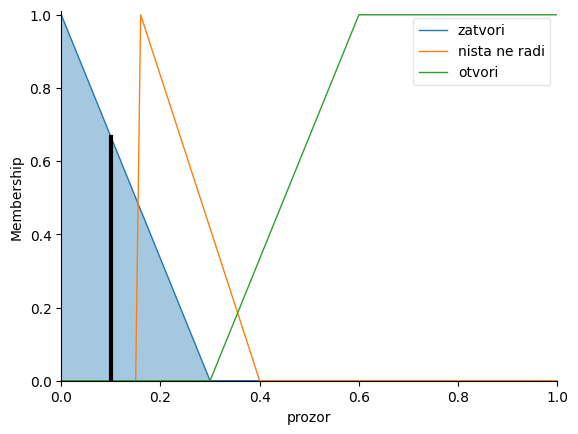

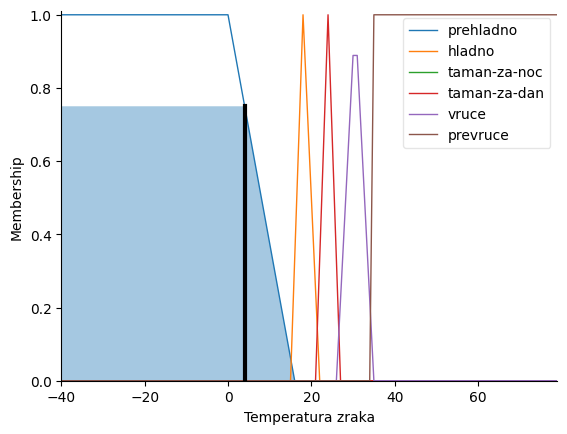

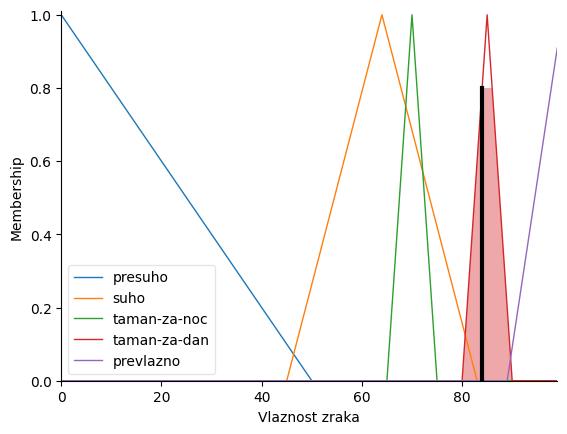

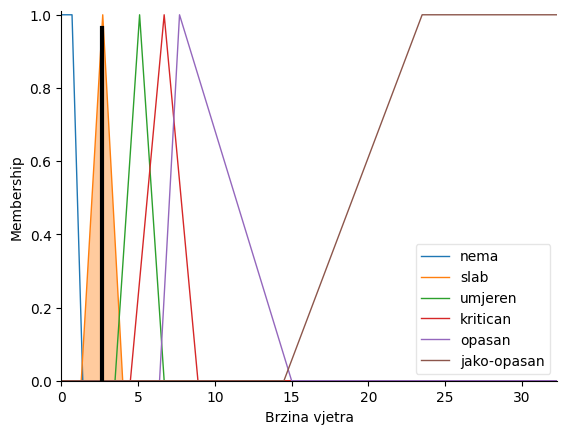

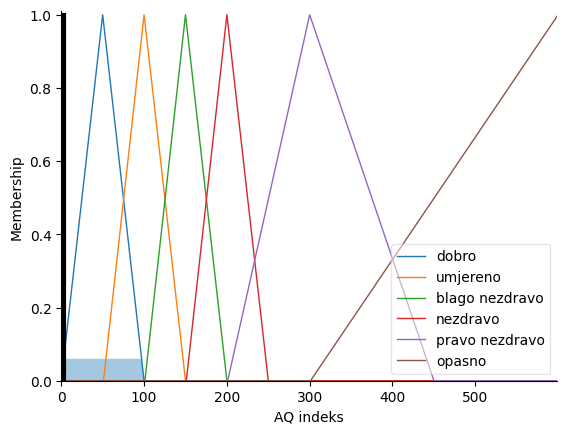

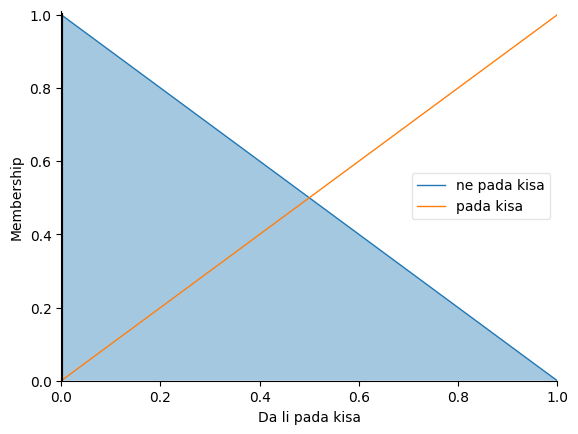

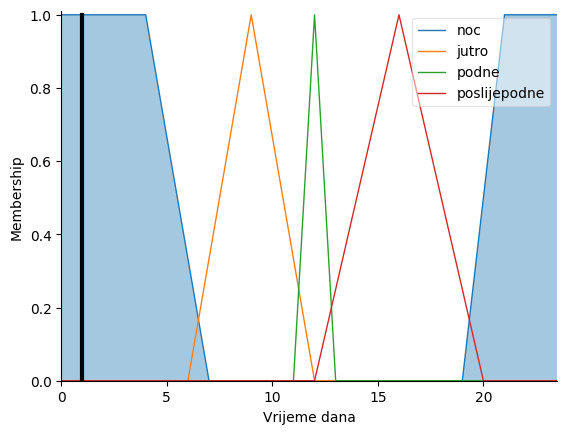

In [59]:
varijable = {
    "TemperaturaZraka":4,
    "VlaznostZraka":84,
    "BrzinaVjetra":2.65,
    "AQI":3,
    "DaLiPadaKisa":False,
    "VrijemeDana":1,
}

vektor = np.array(list(varijable.values()))

fuzzy, zatvori, otvori, nista = paradajz_fuzzy(vektor)
ispis(fuzzy, zatvori, otvori, nista)

Ovdje ćemo demonstrirati jedan scenario gdje će se prozori otvoriti, jer je vrijeme dana noć, a temperatura zraka je taman za dan.

fuzzy: 0.5857142857142856
zatvori: 0.0
otvori: 0.9523809523809521
nista: 0.0

Prozor ce biti otvoren


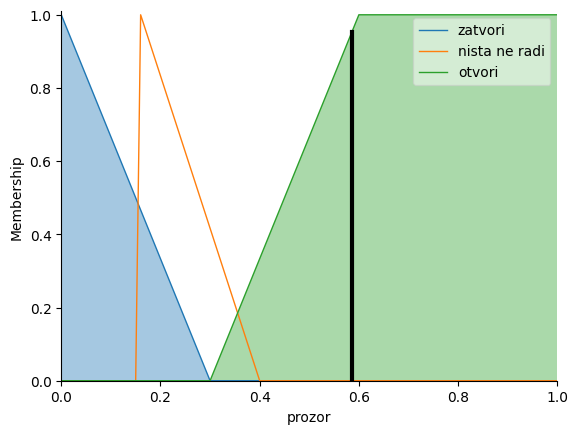

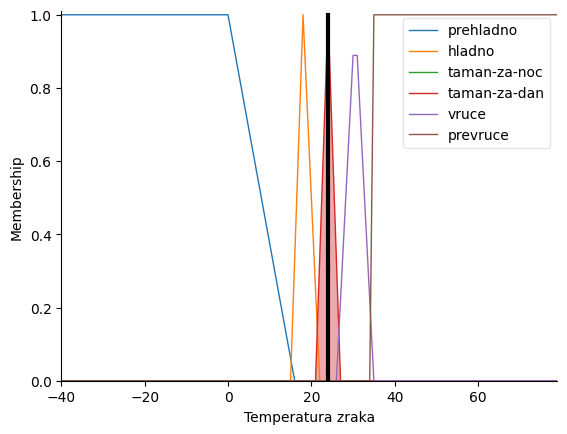

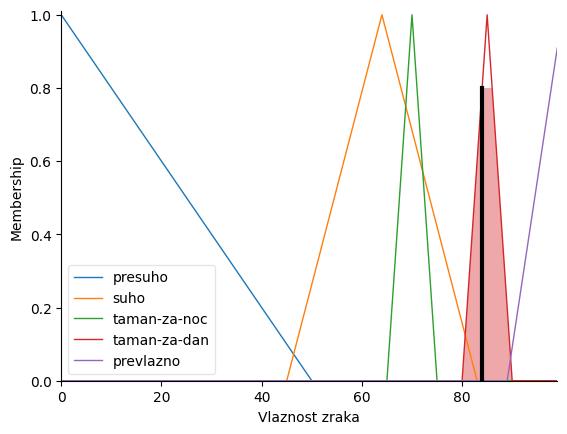

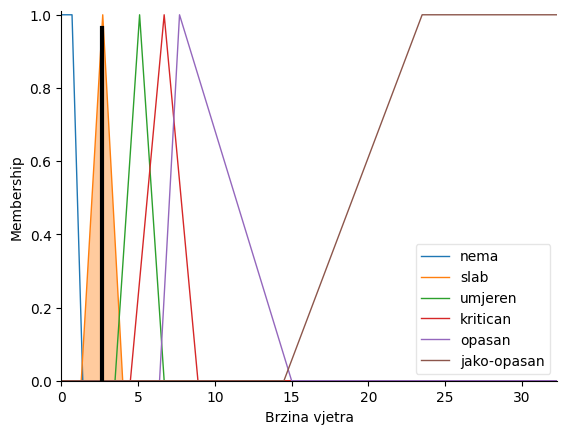

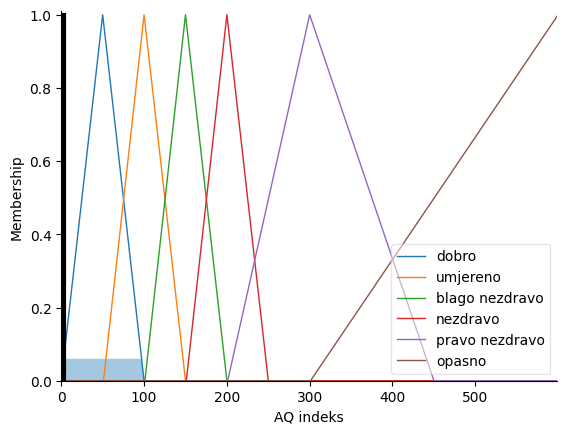

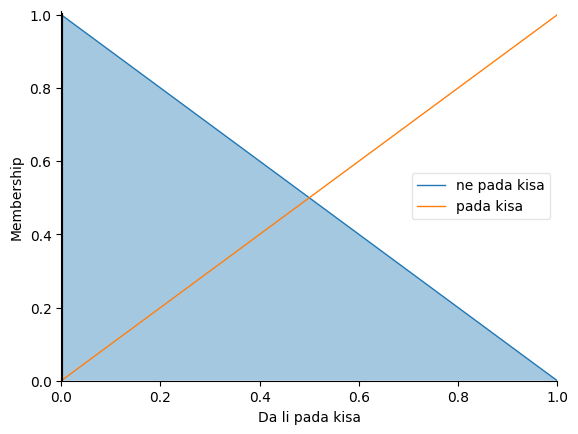

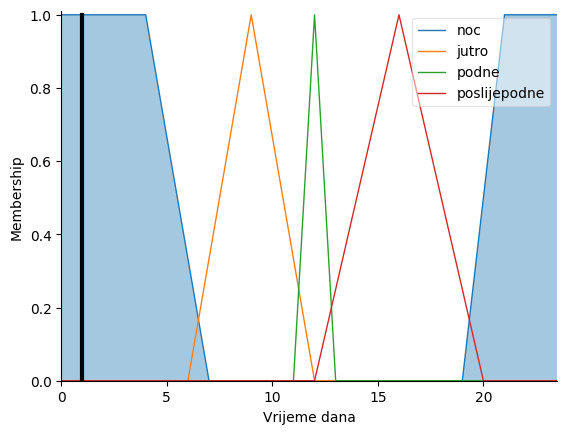

In [60]:
varijable = {
    "TemperaturaZraka":24,
    "VlaznostZraka":84,
    "BrzinaVjetra":2.65,
    "AQI":3,
    "DaLiPadaKisa":False,
    "VrijemeDana":1,
}

vektor = np.array(list(varijable.values()))

fuzzy, zatvori, otvori, nista = paradajz_fuzzy(vektor)
ispis(fuzzy, zatvori, otvori, nista)

Ovdje ćemo demonstrirati jedan scenario gdje će prozori ostati u svom trenutnom stanju, jer temperatura i vlažnost zraka odgovaraju trenutnom dubu dana.

fuzzy: 0.15611736368079304
zatvori: 0.4796087877306898
otvori: 0.0
nista: 0.6117363680793042

Prozor ostaje u onom stanju u kakvom je bio


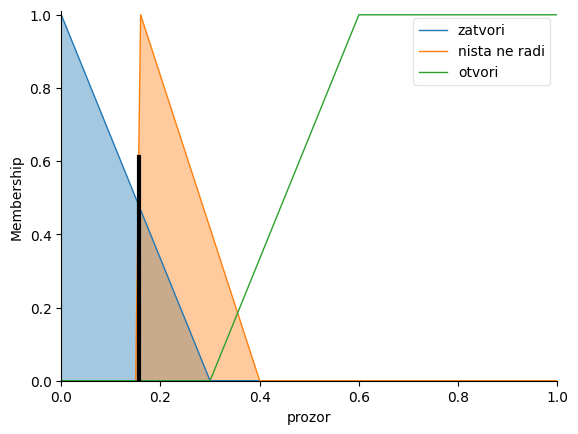

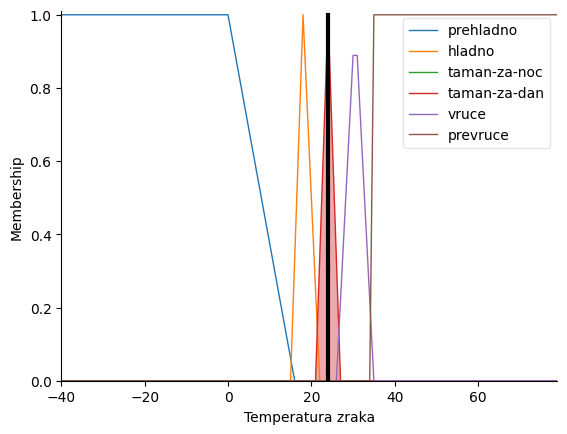

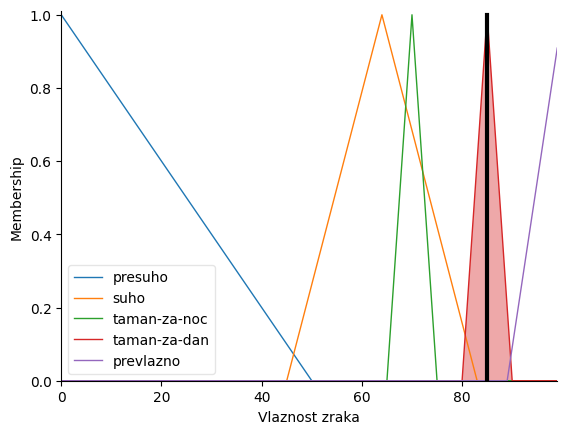

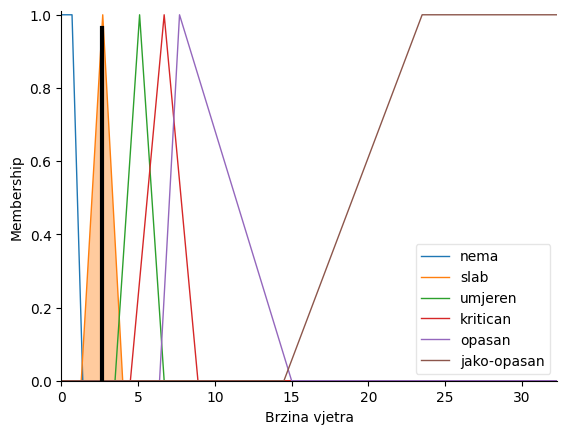

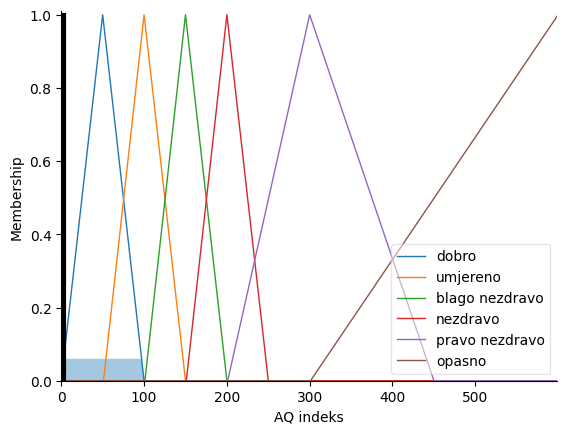

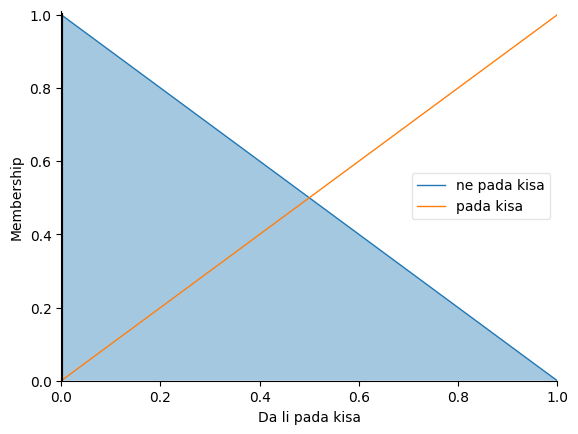

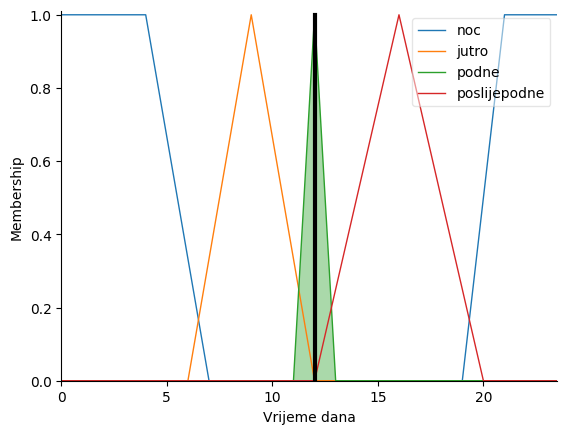

In [57]:
varijable = {
    "TemperaturaZraka":24,
    "VlaznostZraka":85,
    "BrzinaVjetra":2.65,
    "AQI":3,
    "DaLiPadaKisa":False,
    "VrijemeDana":12,
}

vektor = np.array(list(varijable.values()))

fuzzy, zatvori, otvori, nista = paradajz_fuzzy(vektor)
ispis(fuzzy, zatvori, otvori, nista)

Za čitatelje, koji koji žele samostalno isprobati ovaj fuzzy kontroler, mogu to uraditi u narednoj ćeliji mjenjajući vrijednosti `None` u varijabli `varijable`:

fuzzy: 0.5529759359402695
zatvori: 0.0
otvori: 0.8432531198008985
nista: 0.0

Prozor ce biti otvoren


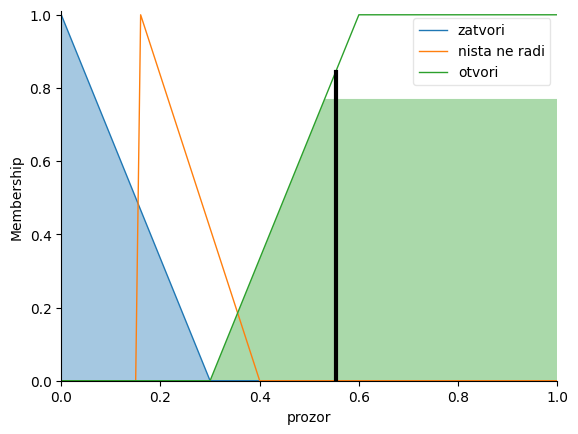

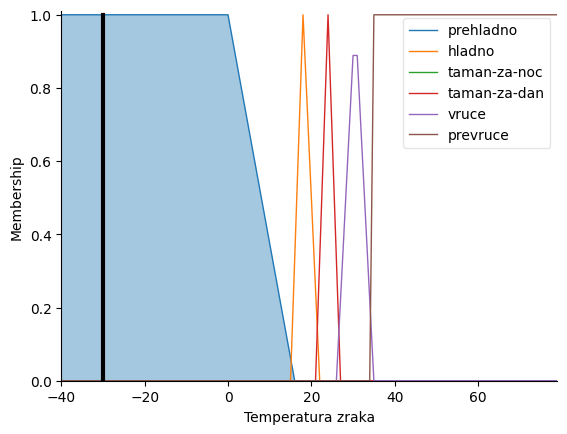

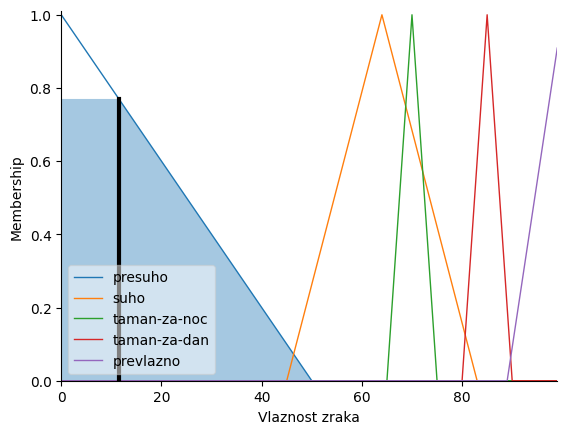

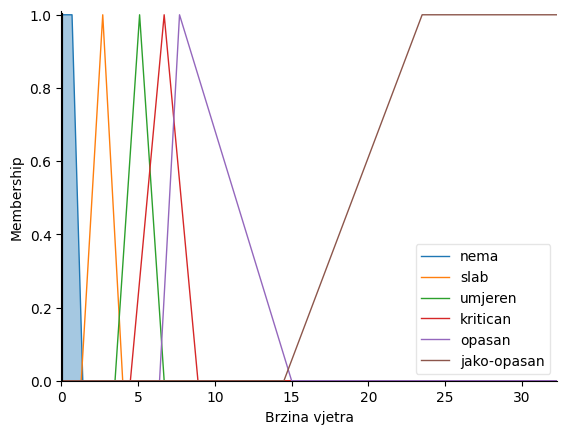

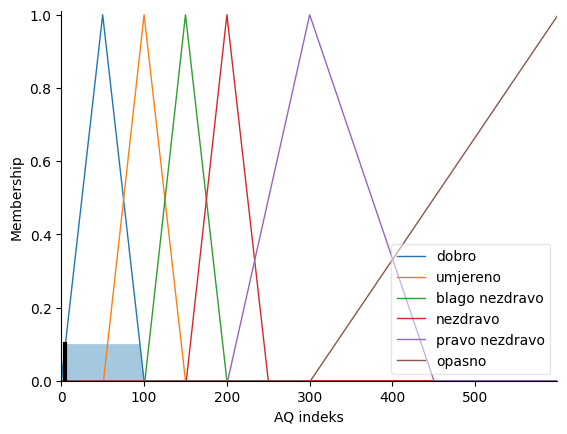

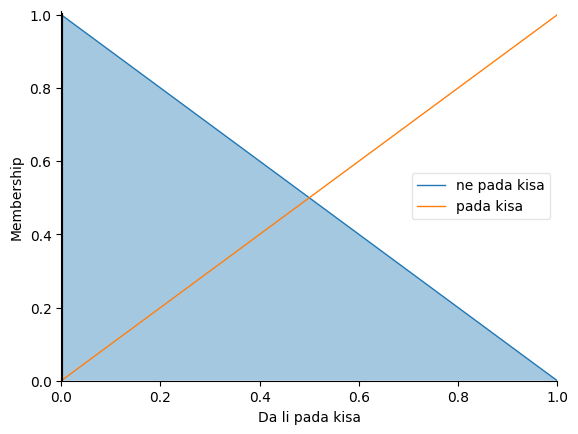

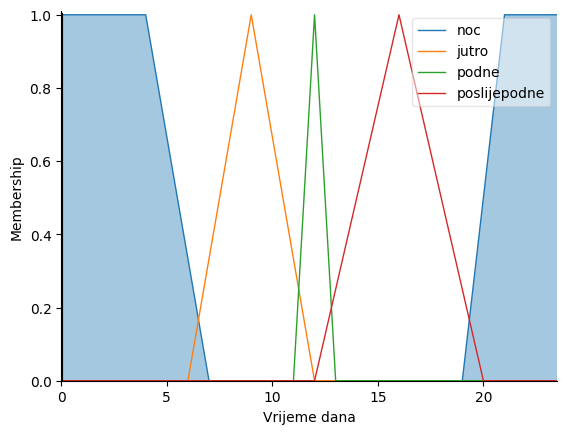

In [ ]:
try:
    varijable = {
        "TemperaturaZraka": None,
        "VlaznostZraka": None,
        "BrzinaVjetra": None,
        "AQI": None,
        "DaLiPadaKisa": None,
        "VrijemeDana": None,
    }

    if None in varijable.values():
        raise ValueError("Neke varijable nisu unesene.")

    vektor = np.array(list(varijable.values()))

    fuzzy, zatvori, otvori, nista = paradajz_fuzzy(vektor)
    ispis(fuzzy, zatvori, otvori, nista)
except ValueError as e:
    print(e)

### ZAKLJUČAK I KRATKA REFLEKSIJA

Izvršen je pokušaj da se fizički realizuje navedeni sistem, međutim, bili smo spriječeni u tome jer nismo imali sve neophodne komponente (kao `Adafruit anemometar`) i poslije se ispostavilo da je `Raspberry pi pico W` bio pokvaren, tako da smo se zadovoljili [simulacijom online](https://wokwi.com/projects/432770743981576193).

Trenutni sistem da bi funkcionisao zahtjeva WiFi mrežu (sam notebook ne treba), a razlog ovakvoj arhitekturi gdje mikrokontroler traži od servera da mu izračuna fuzzy logiku je taj što biblioteka `scikit-fuzzy` nije dobar alat za mikrokontroler poput `Raspberry pi pico W`. Ima prevelik zahtjev za prostornim resursima, kakve bi teško ispunio neki mikrokontroler (`Raspberry pi pico W` ima 4MB<sup>[7](#izvori)</sup> prostora, dok `scikit-fuzzy` zahtjeva sa svim potrebnim zavisnostima (eng. dependencies) 227.1MB). Moguće je da bi se računanje moglo izvesti i direktno na mikrokontroleru, korištenjem druge biblioteke ili pisanjem našeg kontrolera u C++-u, ali ovo je bilo najbrže riješenje, a i članovi tima su se već susretali s korištenim tehnologijama.

Simulaciju smo izvršili preko stranice [wokwi.com](https://wokwi.com), jer jedan od članova tima nije imao verziju softvera [Proteus](https://www.labcenter.com/) koja bi podržala željenu simulaciju sa `Raspberry pi pico W`.



### IZVORI

1. https://www.winter.hr/automatika.htm
1. https://cdn.sparkfun.com/assets/f/7/d/9/c/DHT22.pdf
1. https://cales.arizona.edu/hydroponictomatoes/system.htm
1. https://www.weather.gov/pqr/wind
1. https://stellinamarfa.com/fruits/how-much-wind-is-too-much-for-tomato-plants/
1. https://waqi.info/#/c/3.396/8.206/2.2z
1. https://www.raspberrypi.com/documentation/microcontrollers/pico-series.html






### ULOGE ČLANOVA

Aid Mustafić - Uvod, zaključak i šema spoja  
Adnan Muradbegović - Definicija Skupova fuzzy logike  
Tarik Redžić - Dizajniranje pravila rezonovanja fuzzy logike  
Zlatan Ljutika - Razvijanje serverskog i mikrokontrolerskog koda  